# Building an ARIMA Model for a Financial Dataset

In this notebook, you will build an ARIMA model for AAPL stock closing prices. The lab objectives are:

* Pull data from Google Cloud Storage into a Pandas dataframe
* Learn how to prepare raw stock closing data for an ARIMA model
* Apply the Dickey-Fuller test 
* Build an ARIMA model using the statsmodels library

__Make sure you restart the Python kernel after executing the `pip install` command below__! After you restart the kernel you don't have to execute the command again.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from Google Clod Storage

In this section we'll read some ten years' worth of AAPL stock data into a Pandas dataframe. We want to modify the dataframe such that it represents a time series. This is achieved by setting the date as the index. 

In [3]:
df = pd.read_csv("store1.csv",header=0,index_col=0)

df['Date'] = pd.to_datetime(df['Date'])
# df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

print(df.shape)

df.head()

(4974, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2004-04-08,1854.00,1864.95,1839.70,1853.55,0
2004-04-12,1860.30,1873.75,1828.95,1838.20,0
2004-04-13,1838.50,1885.15,1819.80,1878.45,0
2004-04-15,1878.50,1884.50,1855.00,1861.95,0
2004-04-16,1863.85,1882.55,1861.80,1868.95,0


## Prepare data for ARIMA 

The first step in our preparation is to resample the data such that stock closing prices are aggregated on a weekly basis. 

In [5]:
df_week = df.resample('w').mean()
df_week = df_week[['Close']]
df_week.head()

,Close
Date,
2004-04-11,1853.5500
2004-04-18,1863.1300
2004-04-25,1868.7300
2004-05-02,1809.7125
2004-05-09,1801.3900


Let's create a column for weekly returns. Take the log to of the returns to normalize large fluctuations.

In [6]:
df_week['weekly_ret'] = np.log(df_week['Close']).diff()
df_week.head()

,Close,weekly_ret
Date,,
2004-04-11,1853.5500,NaN
2004-04-18,1863.1300,0.005155
2004-04-25,1868.7300,0.003001
2004-05-02,1809.7125,-0.032091
2004-05-09,1801.3900,-0.004609


In [7]:
# drop null rows
df_week.dropna(inplace=True)

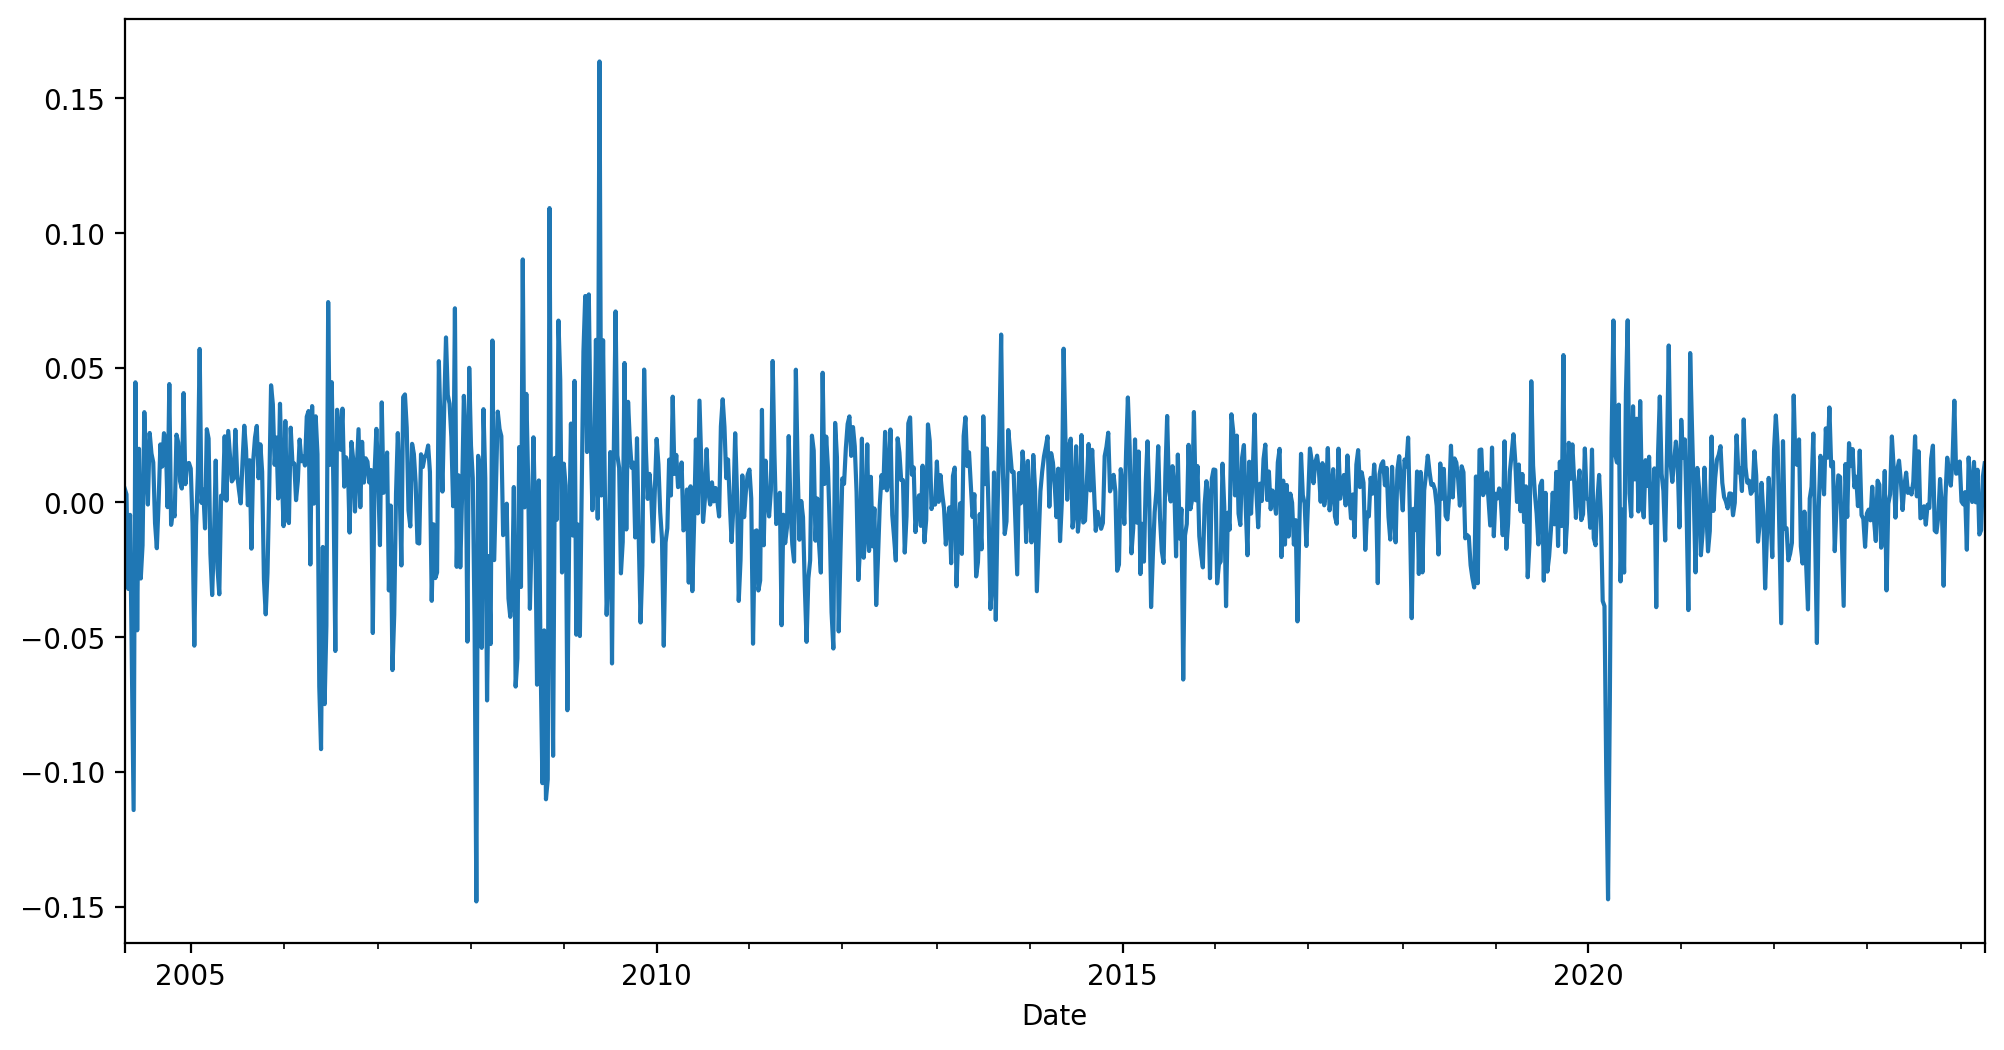

In [8]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [10]:
udiff = df_week.drop(['Close'], axis=1)
udiff.head()

,weekly_ret
Date,
2004-04-18,0.005155
2004-04-25,0.003001
2004-05-02,-0.032091
2004-05-09,-0.004609
2004-05-16,-0.060339


## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [12]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

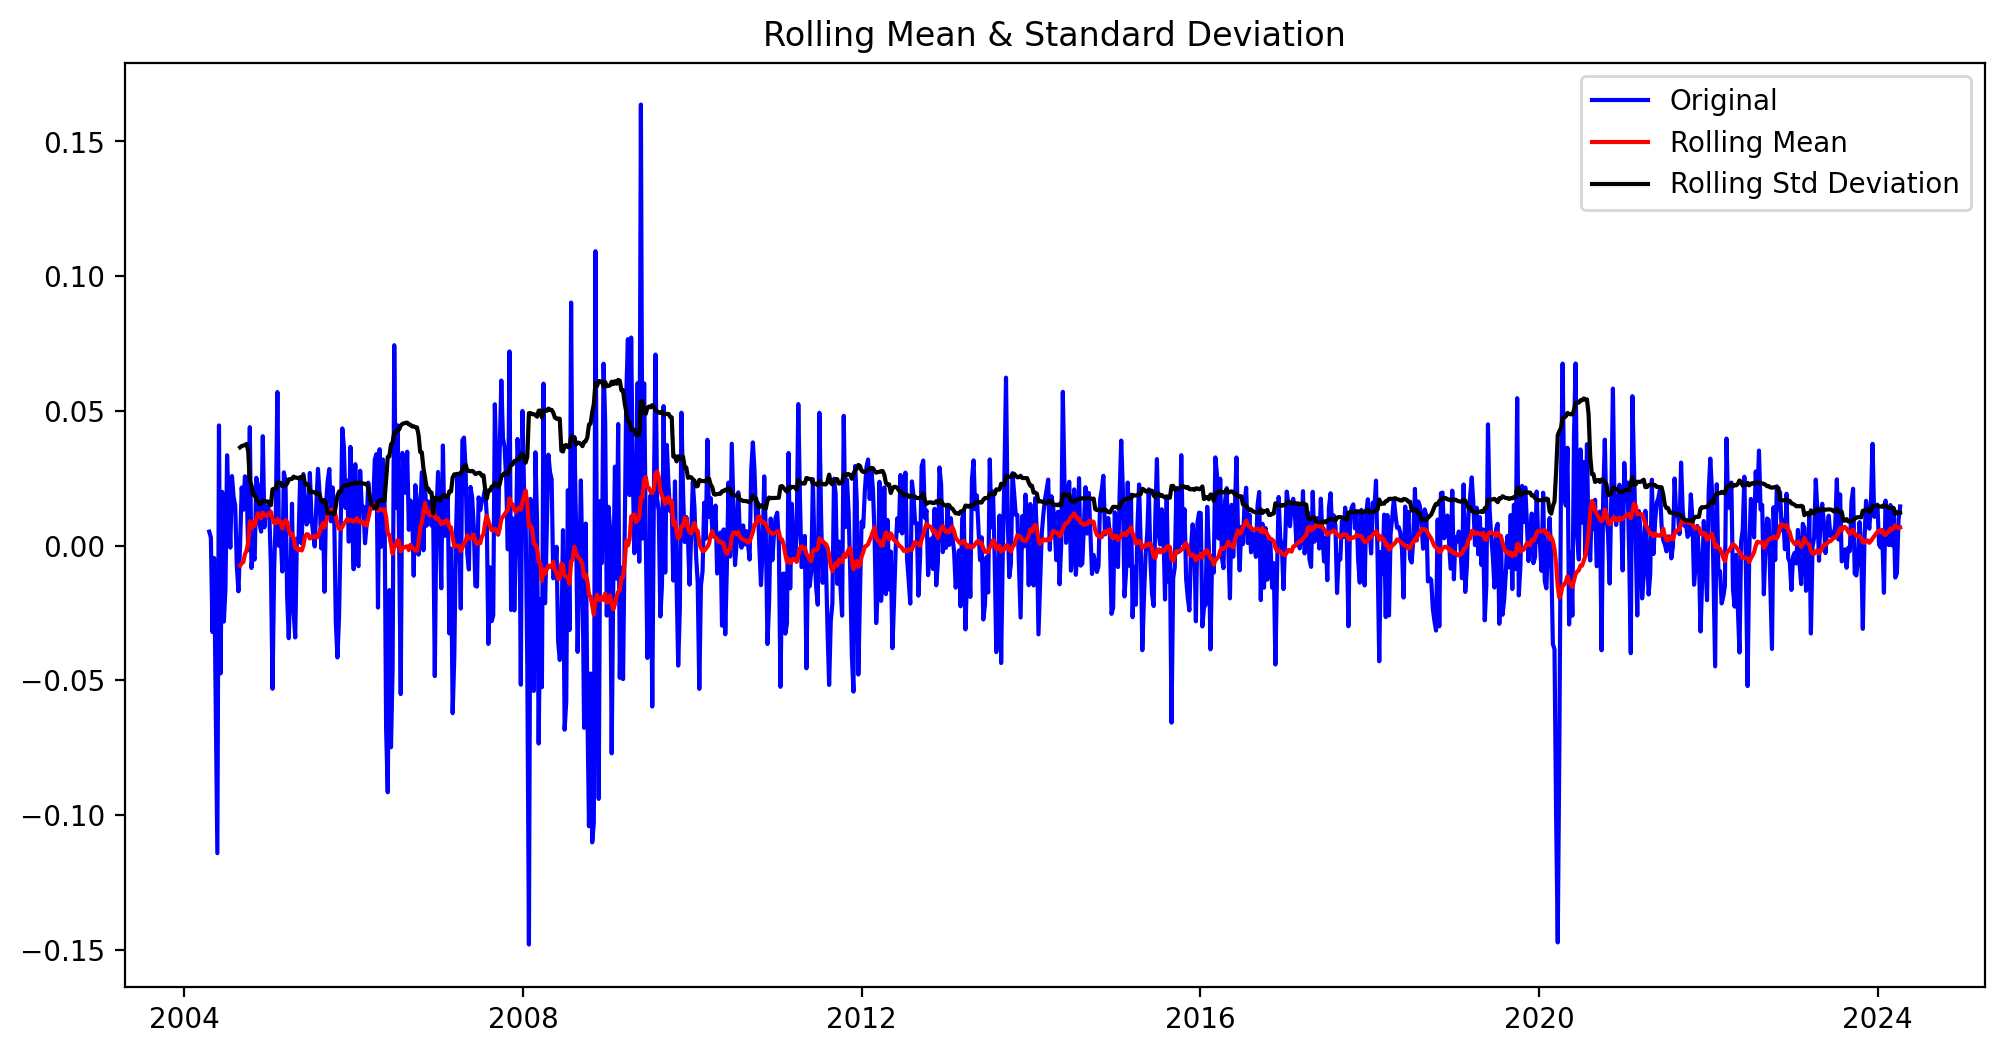

In [13]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [14]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.095446e+01
p-value                        8.632283e-20
#Lags Used                     9.000000e+00
Number of Observations Used    1.033000e+03
Critical Value (1%)           -3.436696e+00
Critical Value (5%)           -2.864342e+00
Critical Value (10%)          -2.568262e+00
dtype: float64

With a p-value < 0.05, we can reject the null hypotehsis. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

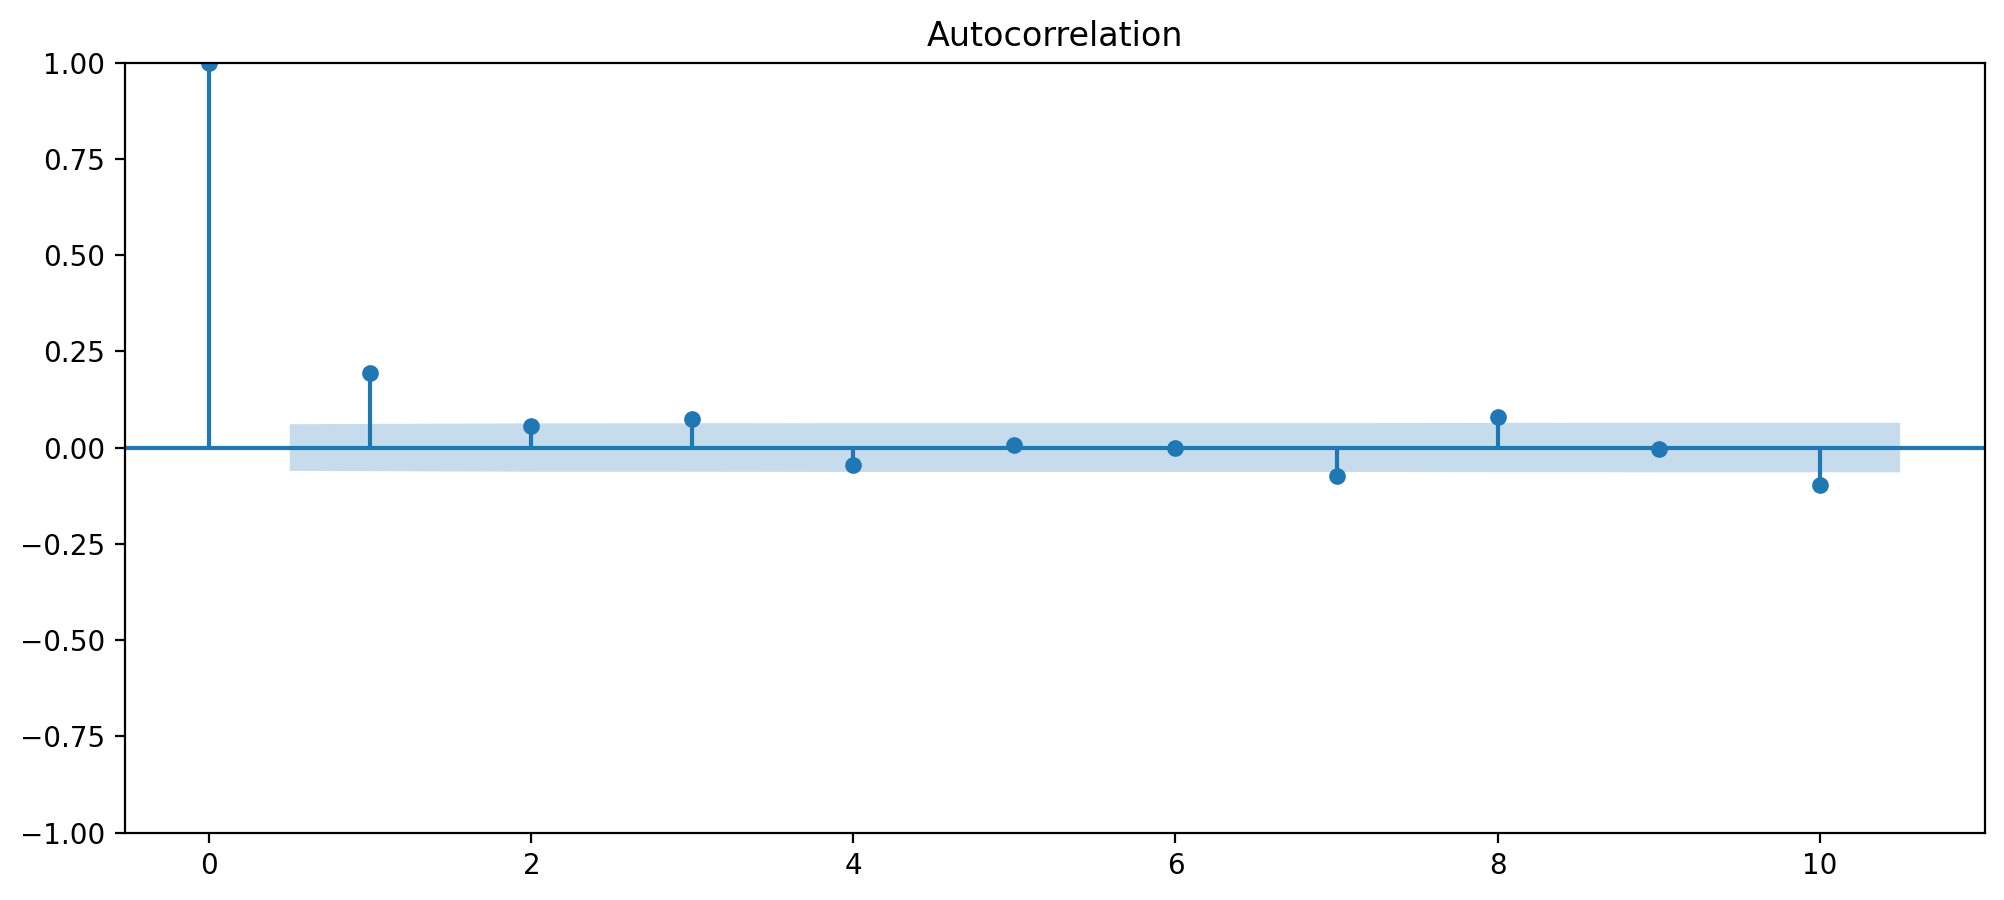

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

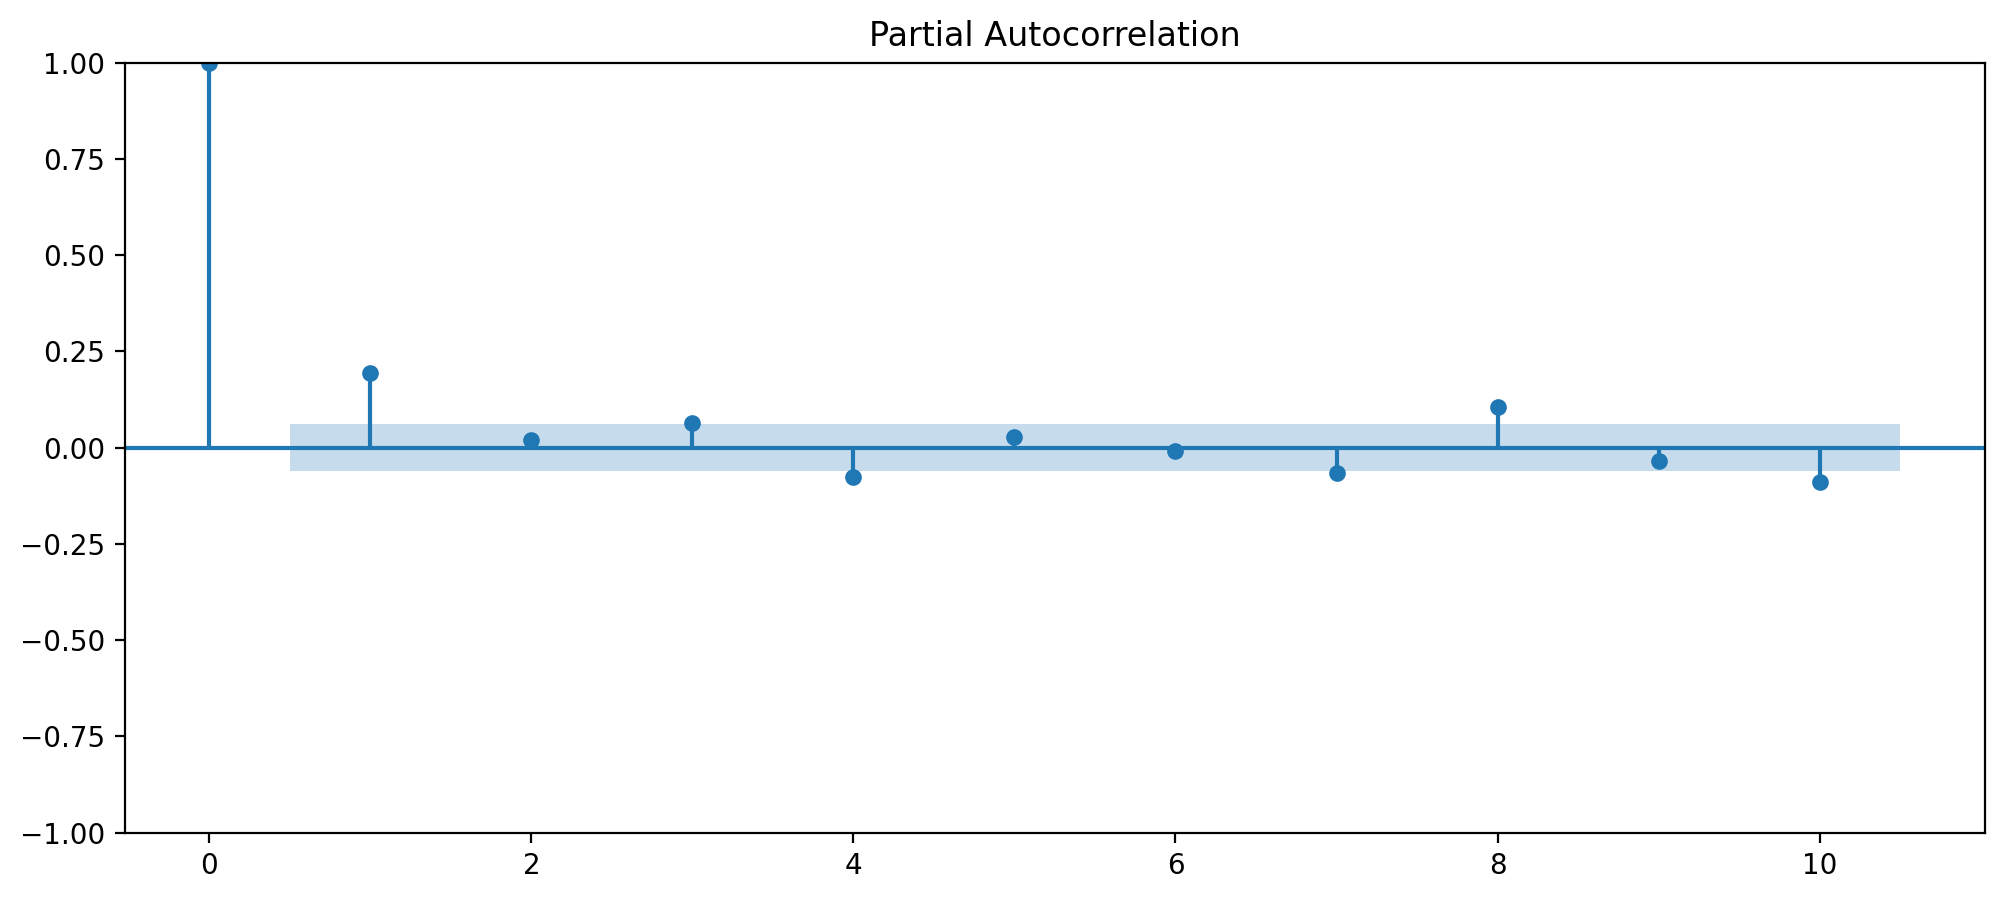

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

<img src="../imgs/How_to_Read_PACF_ACF.jpg" alt="drawing" width="300" height="300"/>

The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Notice that you have to use udiff - the differenced data rather than the original data.
ar1 = ARIMA(udiff.values, order = (3, 0,1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:                 ARIMA(3, 0, 1)   Log Likelihood                2372.405
Date:                Mon, 08 Apr 2024   AIC                          -4732.809
Time:                        01:51:54   BIC                          -4703.110
Sample:                             0   HQIC                         -4721.545
                               - 1043                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.102      0.036       0.000       0.005
ar.L1         -0.2692      0.184     -1.460      0.144      -0.630       0.092
ar.L2          0.0918      0.042      2.167      0.030       0.009       0.175
ar.L3          0.0875      0.024      3.628      0.000       0.040       0.135
ma.L1          0.4616      0.186      2.482      0.013       0.097       0.826
sigma2         0.0006   1.49e-05     41.672      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1101.14
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our model doesn't do a good job predicting variance in the original data (peaks and valleys).

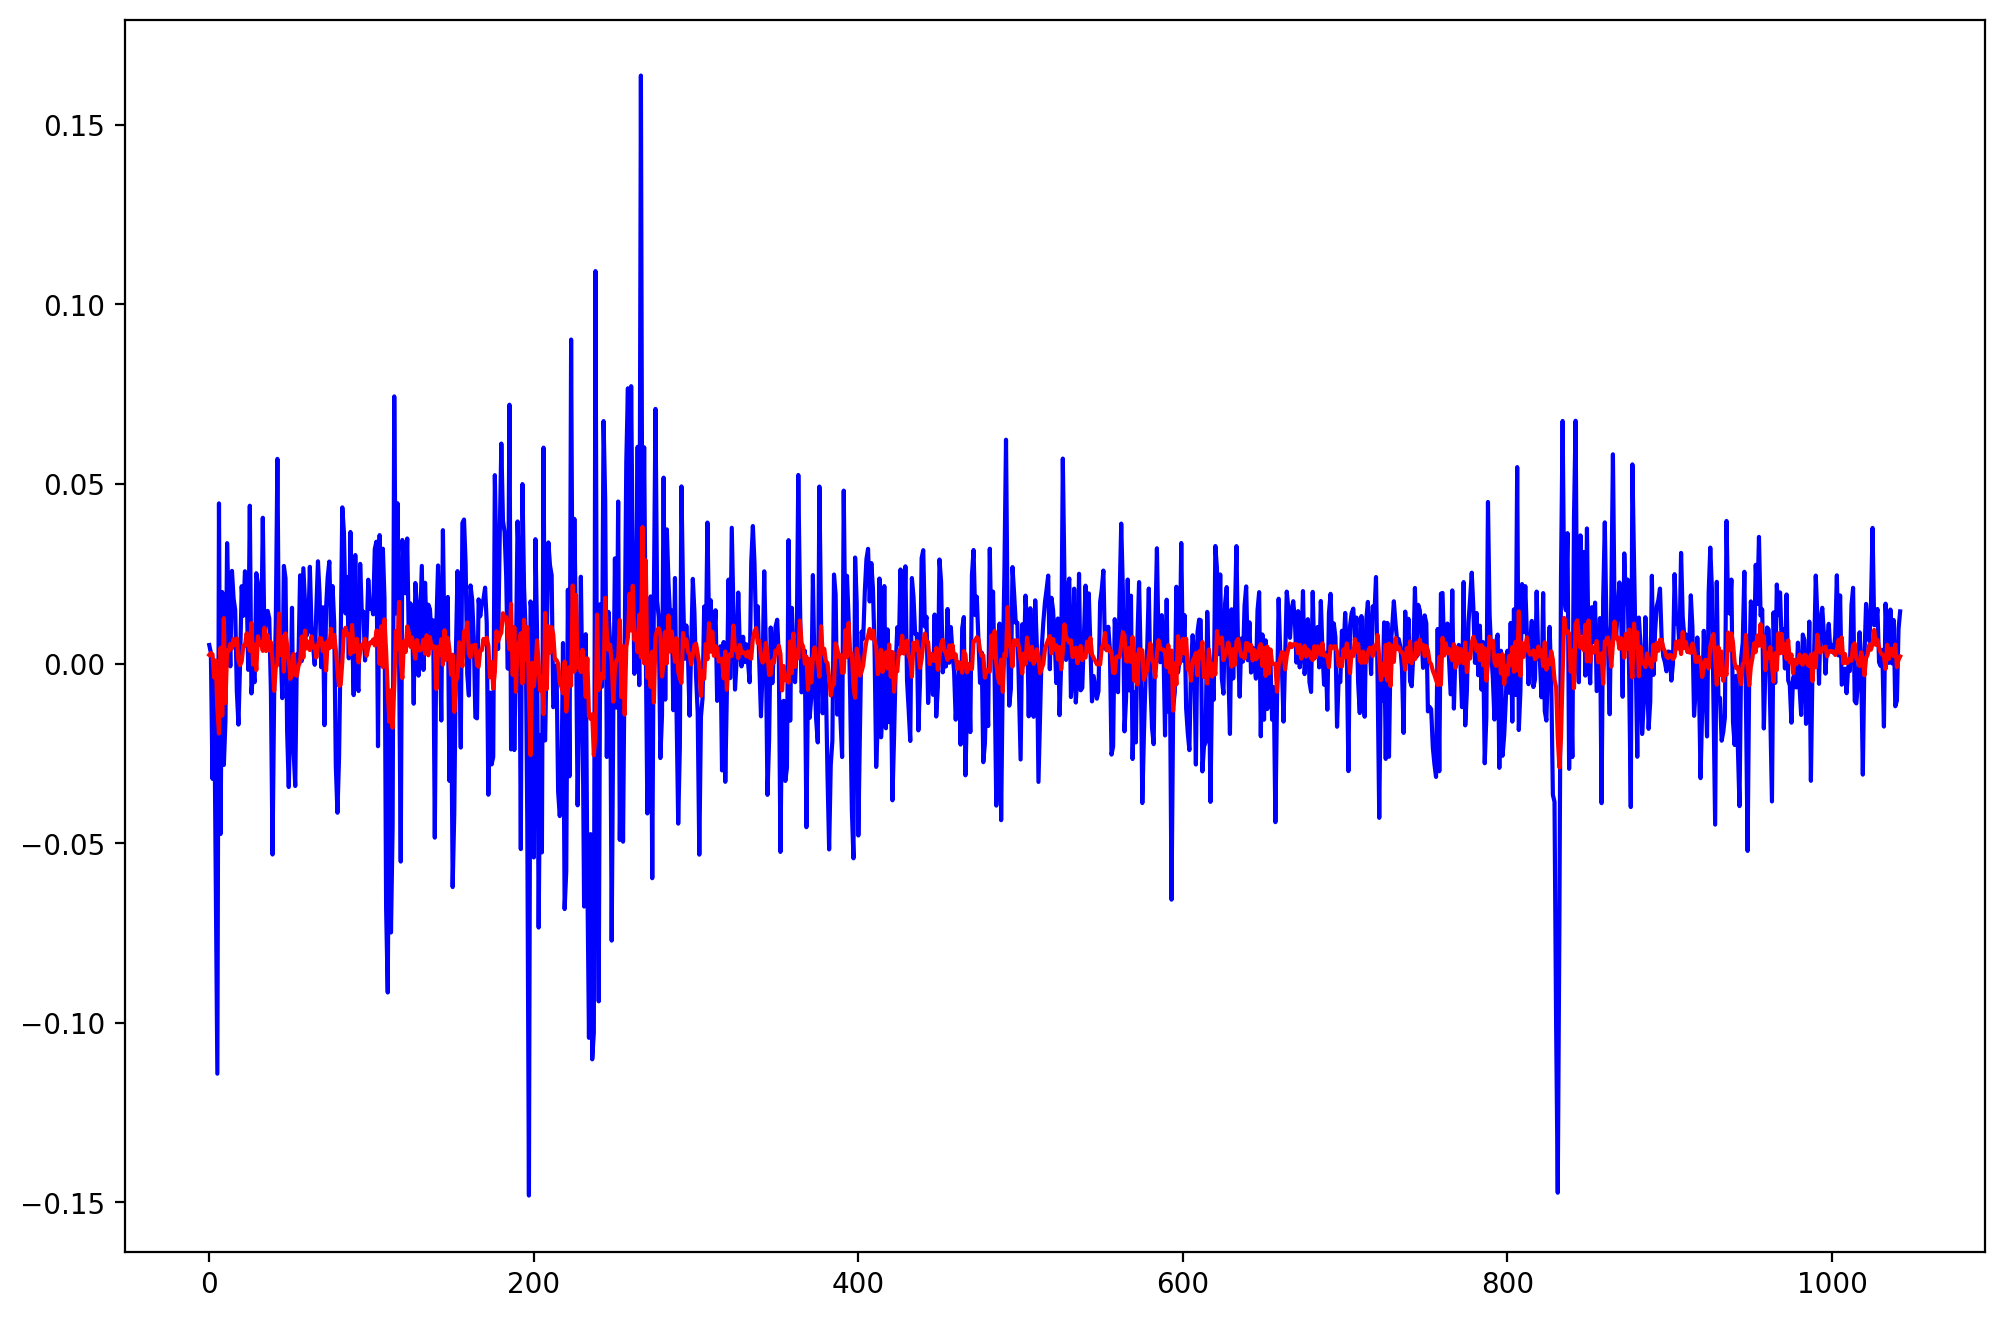

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forecast 2 weeks ahead:

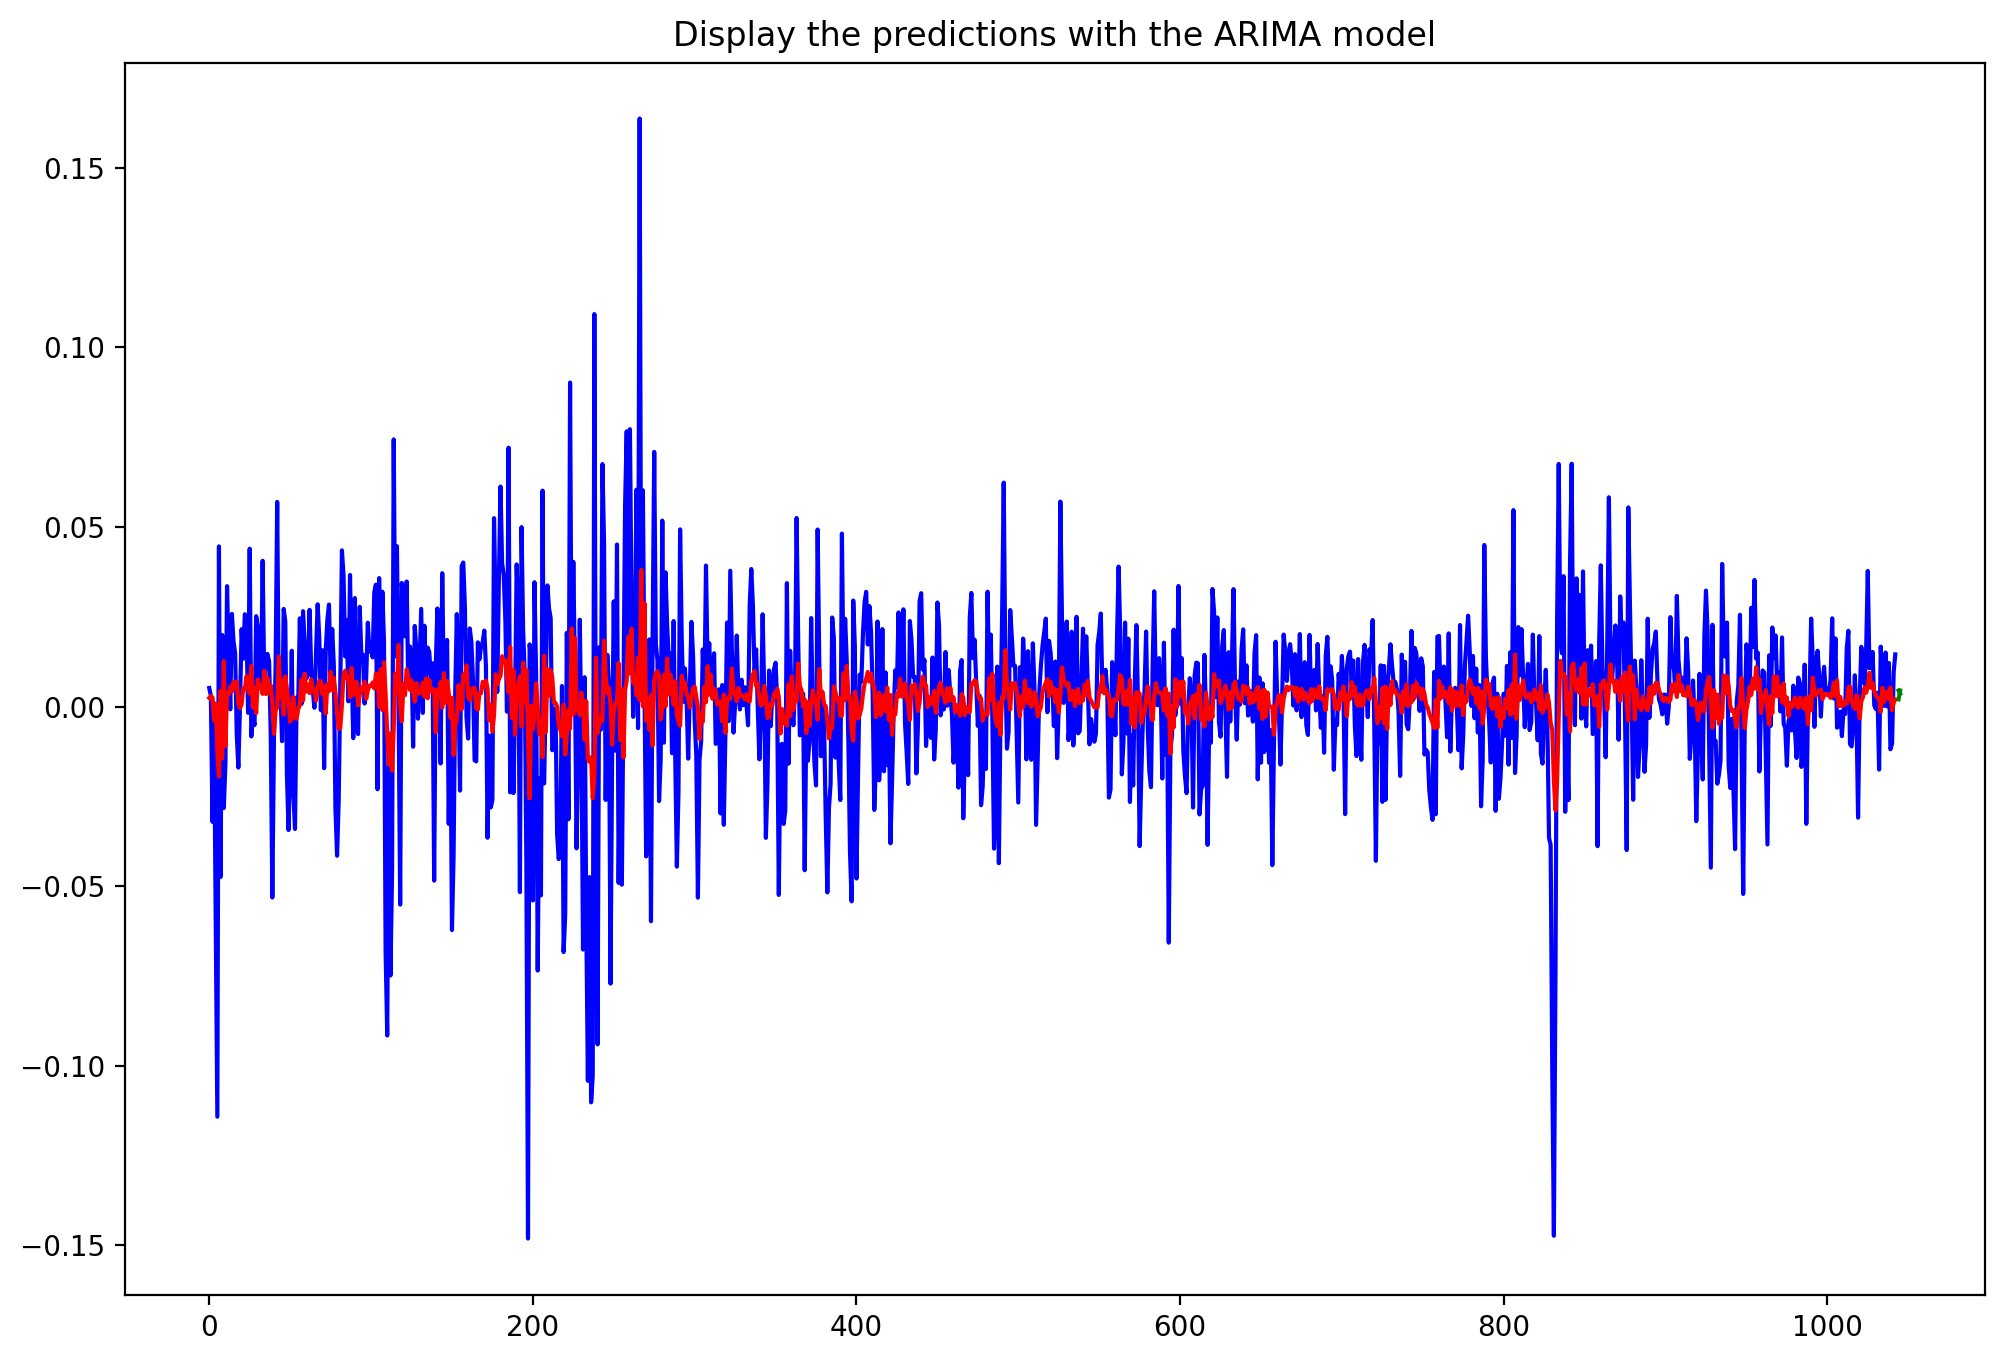

In [19]:
steps = 2

forecast = ar1.forecast(steps=steps)

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.